<div align="center">
    <img src="apple_twitter_banner.jpg" width="450">
</div>

# Apple Brand Sentiment on Twitter at South by Southwest (SXSW)

## Team Members:
* [Sean Harris](https://www.linkedin.com/in/sean-harris-data-sci-and-finance/), Technical Lead
* [Stuart Clark](https://www.linkedin.com/in/sean-harris-data-sci-and-finance/), GitHub Lead
* [Rajesh (Raj) Reddy](https://www.linkedin.com/in/sean-harris-data-sci-and-finance/), Presentation Lead

## Business Situation
We have been tasked with analyzing Twitter 2011 data from SXSW and creating a model of positive and negative tweets. We want to figure out how consumers feel about their products. The data set has been provided to us and already has some classification applied to the tweets such as brand and sentiment.

1.	Explore the data.
2.	Develop a model on positive and negative consumer sentiment.
3.	Provide recommendations to Apple’s Marketing and Product Design teams.

## Data Overview
We used a dataset from data.world provided by CrowdFlower which contains 9,093 tweets about Apple and Google from the South by Southwest (SXSW) Conference. The tweet labels were crowdsourced and reflect which emotion they convey and what product/service/company this emotion is directed at based on the content.

### Filtering
* The data is filtered to only include Apple products based on the newly calculated field called 'new_brand'.
* Dropped 1 tweet that had null value.
* Filtered out neutral to focus on positive and negative sentiment for this first model.

### Data Limitations
* Data only from 2011
* Imbalanced data
* Target column not always accurate



In [1]:
# Import libraries
import pandas as pd
import numpy as np
import re
import unicodedata
from nltk.corpus import stopwords
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

# EDA

In [2]:
# Read in the file with the correct encoding
data = pd.read_csv('brandandproductemotions.csv', encoding='latin1')

# Display the first few rows of the data and rename colummns
data.columns = ['tweet', 'brand_og', 'target']
data.head(4)

,tweet,brand_og,target
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion


In [3]:
print('Unique Target Values:', data['target'].unique())

print('Target Value Counts:', data['target'].value_counts())

Unique Target Values: ['Negative emotion' 'Positive emotion'
 'No emotion toward brand or product' "I can't tell"]
Target Value Counts: No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: target, dtype: int64


In [4]:
data['brand_og'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: brand_og, dtype: int64

In [5]:
# Drop tweets with sentiment of 'I can't tell'
data = data.drop((data.loc[data['target']=="I can't tell"]).index)

# Map the sentiment values in the data to a number
emotions = {'No emotion toward brand or product':0, 'Positive emotion':1, 'Negative emotion':-1}
data['target'] = data['target'].map(emotions)

# Make all cells lower
data = data.applymap(lambda s: s.lower() if type(s) == str else s)

data.head()


,tweet,brand_og,target
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,iphone,-1
1,@jessedee know about @fludapp ? awesome ipad/i...,ipad or iphone app,1
2,@swonderlin can not wait for #ipad 2 also. the...,ipad,1
3,@sxsw i hope this year's festival isn't as cra...,ipad or iphone app,-1
4,@sxtxstate great stuff on fri #sxsw: marissa m...,google,1


In [6]:
# Count occurrences of each value
value_counts = data['target'].value_counts()

# Calculate percentages
total_count = len(data)
percentage_minus_one = (value_counts.get(-1.0, 0) / total_count) * 100
percentage_zero = (value_counts.get(0.0, 0) / total_count) * 100
percentage_one = (value_counts.get(1.0, 0) / total_count) * 100

# Print percentages
print("Percentage of Negative: {:.1f}%".format(percentage_minus_one))
print("Percentage of Neutral: {:.1f}%".format(percentage_zero))
print("Percentage of Positive: {:.1f}%".format(percentage_one))


Percentage of Negative: 6.4%
Percentage of Neutral: 60.3%
Percentage of Positive: 33.3%


In [7]:
# Find null values
data.isna().sum()

tweet          1
brand_og    5655
target         0
dtype: int64

In [8]:
#how long is the longest review?
length_tweet = data.tweet.str.len()
print(f'longest review {length_tweet.max()}')
print(f'shortest review {length_tweet.min()}')

longest review 178.0
shortest review 11.0


# Data Cleaning

In [9]:
# Replace NaN with "unknown" in the 'brand_og' column
data['brand_og'].fillna('unknown', inplace=True)
# Drop null in 'tweet'
data = data.dropna(subset=['tweet'])

In [10]:
# function to create new brand column based on values in tweet
def check_substring(tweet):
    # check if any of the sub strings appear individually
    apple_list = any(substring in tweet for substring in apple)
    android_list = any(substring in tweet for substring in android)

    if apple_list and android_list:
        return "both"
    elif apple_list:
        return "apple"
    elif android_list:
        return "android"
    else:
        return "unknown"
    
# Key words to search for to ID brand
apple = ['iphone',
         'ipad',
         'itunes',
         'apple']
android = ['google',
           'samsung',
           'android']

# Run function and create new_brand column
data['new_brand'] = data['tweet'].apply(check_substring)

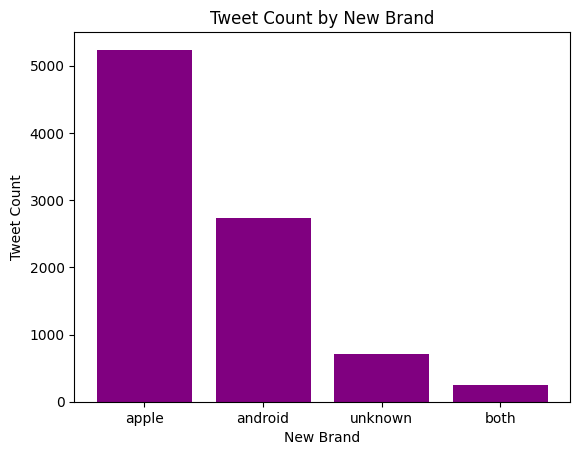

In [11]:
tweet_counts_by_brand = data['new_brand'].value_counts()
plt.bar(tweet_counts_by_brand.index, tweet_counts_by_brand.values, color='purple')
plt.xlabel('New Brand')
plt.ylabel('Tweet Count')
plt.title('Tweet Count by New Brand')
plt.show()


In [12]:
# Filter on Apple only
data_apple = data[~data['new_brand'].isin(['android', 'unknown'])]

print(data_apple.info())
print(data_apple['new_brand'].value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5493 entries, 0 to 9091
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      5493 non-null   object
 1   brand_og   5493 non-null   object
 2   target     5493 non-null   int64 
 3   new_brand  5493 non-null   object
dtypes: int64(1), object(3)
memory usage: 214.6+ KB
None
apple    5237
both      256
Name: new_brand, dtype: int64


In [13]:
def clean_tweet(text):
    # Remove hashtags (words starting with '#')
    text = re.sub(r'#\w+', '', text)
    
    # Handle RT tags
    text = re.sub(r'[Rr][Tt]', '', text)
    
    # Remove mentions (words starting with '@')
    text = re.sub(r'@\w+', '', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove non-ASCII characters
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
        
    # Remove special characters and numbers not adjacent to text
    text = re.sub(r'\b\d+\b', '', text)

    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text)     # Remove extra spaces
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    cleaned_text = [word for word in text.split() if word not in stop_words]

    # Unique words to remove, add more as needed
    words_to_remove = ['Austin', 'Link', 'Sxsw', 'sxsw']

    for word in words_to_remove:
        cleaned_text = [w for w in cleaned_text if not re.match(r'\b{}\b'.format(word), w, flags=re.IGNORECASE)]

    return ' '.join(cleaned_text)

In [14]:
# Apply the clean_tweet function and see output
data_apple['cleaned_tweet'] = data_apple['tweet'].apply(clean_tweet)
data_apple.head()

,tweet,brand_og,target,new_brand,cleaned_tweet
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,iphone,-1,apple,3g iphone hrs tweeting dead need upgrade plugi...
1,@jessedee know about @fludapp ? awesome ipad/i...,ipad or iphone app,1,apple,know awesome ipadiphone app youll likely appre...
2,@swonderlin can not wait for #ipad 2 also. the...,ipad,1,apple,wait also sale
3,@sxsw i hope this year's festival isn't as cra...,ipad or iphone app,-1,apple,hope years festival isnt crashy years iphone app
5,@teachntech00 new ipad apps for #speechtherapy...,unknown,0,apple,new ipad apps communication showcased conference


In [15]:
# Creating function for calculating positive, negative and neutral
def ratio(x):
 if x > 0:
    return 1
 elif x == 0:
    return 0
 else:
    return -1

# Creating new column and rounding to one decimal for easier viewing
data_apple['polarity'] = data_apple['cleaned_tweet'].apply(lambda text: TextBlob(text).sentiment.polarity)
data_apple['analysis'] = data_apple['polarity'].apply(ratio)
data_apple['analysis'] = data_apple['analysis'].astype(float)
data_apple['analysis'] = data_apple['analysis'].round(3)

# Value counts for 'target'
target_counts = data_apple['target'].value_counts()

# Value counts for 'analysis'
analysis_counts = data_apple['analysis'].value_counts()

print("Value counts for 'target':")
print(target_counts)

print("\nValue counts for 'analysis':")
print(analysis_counts)

Value counts for 'target':
 0    2929
 1    2144
-1     420
Name: target, dtype: int64

Value counts for 'analysis':
 1.0    2466
 0.0    2464
-1.0     563
Name: analysis, dtype: int64


In [16]:
# Taking borderline negative tweets that are classified as neutral and converting them to negative to begin to address the imbalance
data_apple.loc[(data_apple['target'] == 0) & (data_apple['analysis'] == -1), 'target'] = data_apple['analysis']

# Value counts for 'target'
target_counts = data_apple['target'].value_counts()

# Value counts for 'analysis'
analysis_counts = data_apple['analysis'].value_counts()

print("Value counts for 'target':")
print(target_counts)

print("\nValue counts for 'analysis':")
print(analysis_counts)

Value counts for 'target':
 0    2647
 1    2144
-1     702
Name: target, dtype: int64

Value counts for 'analysis':
 1.0    2466
 0.0    2464
-1.0     563
Name: analysis, dtype: int64


In [17]:
# drop nuetral sentiment to focus on positive and negative sentiment for this itteration
data_apple = data_apple.drop(data_apple[data_apple['target'] == 0.0].index)

# Value counts for 'target'
target_counts = data_apple['target'].value_counts()

# Value counts for 'analysis'
analysis_counts = data_apple['analysis'].value_counts()

print("Value counts for 'target':")
print(target_counts)
print("Negative sentiment is 24.7% of the data")

Value counts for 'target':
 1    2144
-1     702
Name: target, dtype: int64
Negative sentiment is 24.7% of the data


# Visualizations

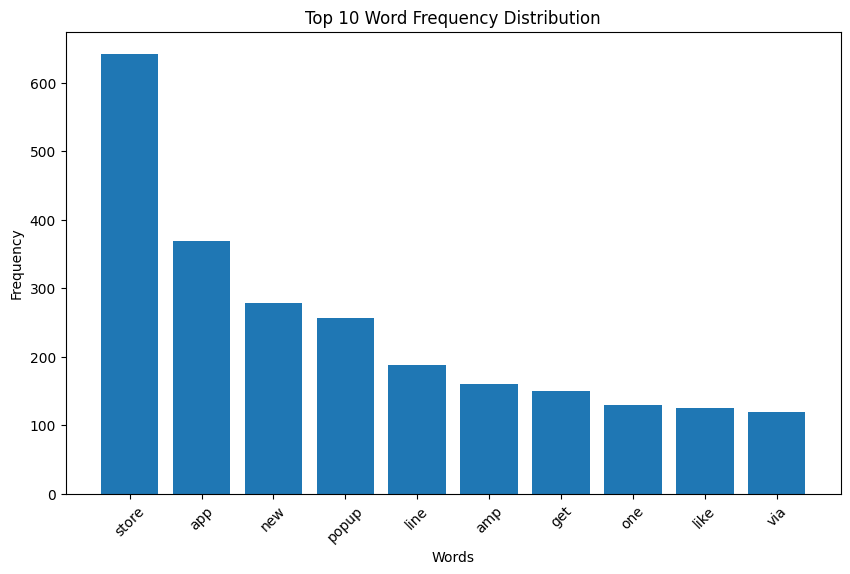

In [18]:
import matplotlib.pyplot as plt
from collections import Counter

exclude_words = ['ipad', 'apple', 'iphone', 'ipad2', 'im']

# Combine all tweets into a single string
all_tweets = ' '.join(data_apple['cleaned_tweet'])

# Split the string into individual words
words = all_tweets.split()

# Remove excluded words
words = [word for word in words if word.lower() not in exclude_words]

# Count the frequency of each word
word_counts = Counter(words)

# Get the top 10 most common words
top_words = word_counts.most_common(10)

# Separate the words and their frequencies
word_list, frequency_list = zip(*top_words)

# Plot the frequency distribution
plt.figure(figsize=(10, 6))
plt.bar(word_list, frequency_list)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Word Frequency Distribution')
plt.xticks(rotation=45)
plt.show()

In [19]:
data_apple.head()

,tweet,brand_og,target,new_brand,cleaned_tweet,polarity,analysis
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,iphone,-1,apple,3g iphone hrs tweeting dead need upgrade plugi...,-0.200000,-1.0
1,@jessedee know about @fludapp ? awesome ipad/i...,ipad or iphone app,1,apple,know awesome ipadiphone app youll likely appre...,0.466667,1.0
2,@swonderlin can not wait for #ipad 2 also. the...,ipad,1,apple,wait also sale,0.000000,0.0
3,@sxsw i hope this year's festival isn't as cra...,ipad or iphone app,-1,apple,hope years festival isnt crashy years iphone app,0.000000,0.0
8,beautifully smart and simple idea rt @madebyma...,ipad or iphone app,1,apple,beautifully sma simple idea wrote ipad app,0.425000,1.0


In [20]:
# Creating dataframes for positive, neutral, and negative sentiments
df_pos = data_apple[data_apple['target'] == 1]
df_neg = data_apple[data_apple['target'] == -1]

In [21]:
def generate_word_cloud(text):
    if text:  # Check if the text string is empty
        wordcloud = WordCloud(width=800, height=800,
                              background_color='white',
                              colormap='Oranges',
                              min_font_size=10).generate(text)

        plt.figure(figsize=(5, 5), facecolor=None)
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.tight_layout(pad=0)
    else:
        print("The text for wordcloud is empty.")

In [22]:
def extract_prod(df, prod, str_replace):
    '''Extract a new dataframe using prod string as filter'''

    # Make a new DataFrame series using input df
    df_new = df['cleaned_tweet']

    # Filter for rows only including specific prod string
    filtered_df = df_new[df_new.str.contains(prod)]

    # Remove all substrings from str_replace list
    pattern = '|'.join(map(re.escape, str_replace))
    filtered_df = filtered_df.str.replace(pattern, '')

    # Return filtered_df of tweets only related to input prod string
    return filtered_df

In [32]:
# Checking to see if extract_prod is working properly
# Return a df of tweets related to ipads in positive sentiments df
df_ipad = extract_prod(df_pos, 'ipad', apple)


In [24]:

def prod_wordcloud(df_tweet, product, list_remove):
    ''' Takes in df_tweet, filters by input product string, then creates
        positive, negative, and neutral wordclouds for product'''
    
    # Convert product string to title for visualization purposes
    prod = product.title()

    # Extracting tweets by input product for positive sentiment dataframe
    df_posit = extract_prod(df_pos, product, list_remove)

    # Join all the tweets together
    text_positive = ' '.join(df_posit)

    # Generate wordcloud for positive sentiments for input product
    generate_word_cloud(text_positive)
    plt.title(f"Word Cloud - {prod} Positive Sentiment")
    plt.show()

    # Extracting tweets by input product for negative sentiment dataframe
    df_negat = extract_prod(df_neg, product, list_remove)

    # Join all the tweets together
    text_negative = ' '.join(df_negat)

    # Generate wordcloud for negative sentiments for input product
    generate_word_cloud(text_negative)
    plt.title(f"Word Cloud - {prod} Negative Sentiment")
    plt.show()

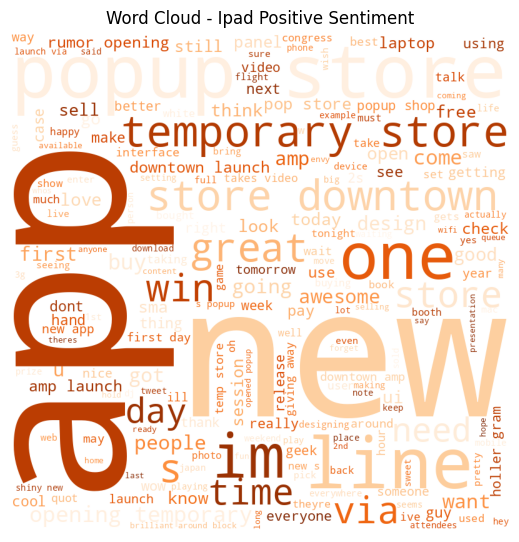

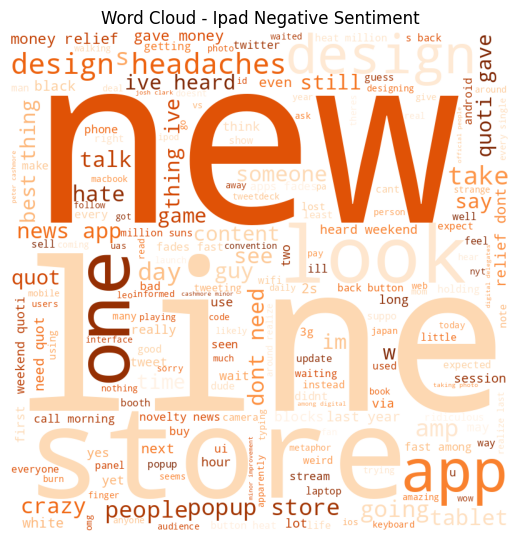

In [33]:
prod_wordcloud(data_apple, 'ipad', apple)

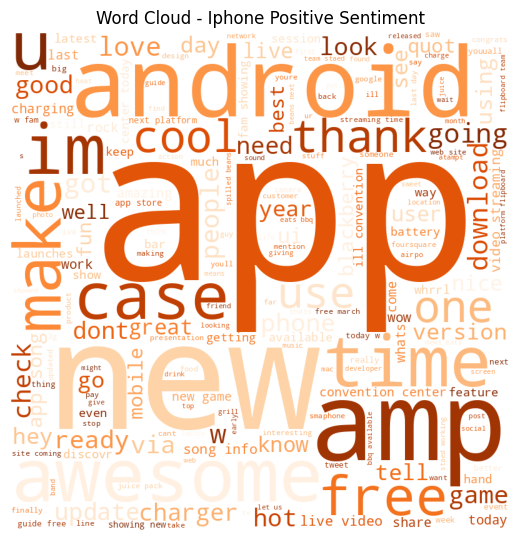

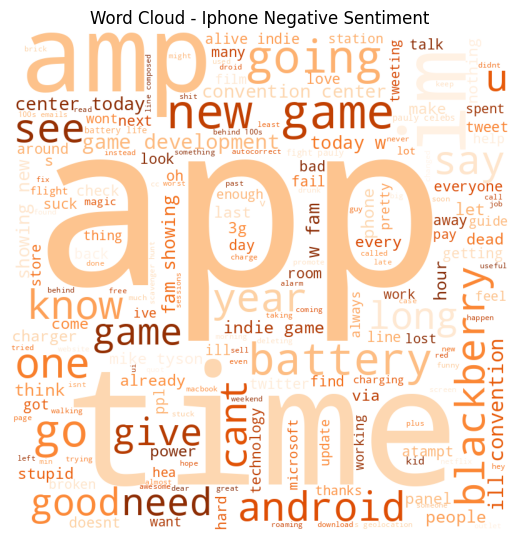

In [34]:
prod_wordcloud(data_apple, 'iphone', apple)

# Modeling

In [27]:
X = data_apple['cleaned_tweet']
y = data_apple['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [28]:
# Default parameters
default_models = {
    'LogisticRegression': {'classifier': LogisticRegression(random_state=42)},
    'MultinomialNB': {'classifier': MultinomialNB()},
    'DecisionTree': {'classifier': DecisionTreeClassifier(random_state=42)},
    'RandomForest': {'classifier': RandomForestClassifier(random_state=42)},
    'ExtraTrees': {'classifier': ExtraTreesClassifier(random_state=42)},
    'GradientBoost': {'classifier':GradientBoostingClassifier(random_state=42)},
    'SGDClassifier': {'classifier': SGDClassifier(random_state=42)}}

In [29]:
def run_model_with_grid_search_and_cv(models, model_type, cmap, X, y, n_splits=5):
    metric_table = pd.DataFrame(columns=['Model', 'CV Score', 'Accuracy', 'F1 Score', 'Type'])

    # Hyperparameter grids for each model
    param_grids = {
        'LogisticRegression': {
            'classifier__C': [0.1, 1, 10],
            'classifier__penalty': ['l2'],
            'classifier__max_iter': [100, 500, 1000]
        },
        'MultinomialNB': {
            'classifier__alpha': [0.1, 1.0, 10.0],
        },
        'RandomForest': {
            'classifier__n_estimators': [50, 100, 200],
            'classifier__max_depth': [None, 10, 20],
        },
        'DecisionTree': {
            'classifier__max_depth': [None, 10, 20, 30],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__min_samples_leaf': [1, 2, 4]
        },
        'ExtraTrees': {
            'classifier__n_estimators': [10, 50, 100, 200],
            'classifier__max_depth': [None, 10, 20, 30],
            'classifier__min_samples_split': [2, 5, 10]
        },
        'GradientBoost': {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__learning_rate': [0.1, 0.01, 0.001],
            'classifier__max_depth': [3, 5, 10]
        },
        'SGDClassifier': {
            'classifier__alpha': [0.0001, 0.001, 0.01, 0.1],
            'classifier__loss': ['hinge', 'log'],
            'classifier__penalty': ['none', 'l2', 'l1', 'elasticnet']
        }
    }

    for name, model in models.items():
        print(f'Running... {name} Model')
        pipeline = Pipeline(steps=[('tfidf', TfidfVectorizer()), ('classifier', model['classifier'])])

        # Perform grid search with cross-validation
        grid_search = GridSearchCV(pipeline, param_grids[name], cv=KFold(n_splits=n_splits, shuffle=True, random_state=42), n_jobs=-1)
        grid_search.fit(X, y)

        # Print the best hyperparameters
        print(f'Best hyperparameters for {name}: {grid_search.best_params_}')

        # Perform k-fold cross-validation
        cross_val_pred = cross_val_predict(grid_search.best_estimator_, X, y, cv=KFold(n_splits=n_splits, shuffle=True, random_state=42))
        cross_val_mean = round(np.mean(cross_val_pred == y), 4)
        f1 = f1_score(y, cross_val_pred, average='weighted')
        accuracy = accuracy_score(y, cross_val_pred)

        metric_table = metric_table.append({'Model': name,
                                            'CV Score': cross_val_mean,
                                            'Accuracy': accuracy,
                                            'F1 Score': round(f1, 4),
                                            'Type': model_type}, ignore_index=True)

        print(f'Cross Validation Score: {cross_val_mean}')
        print(f'Test Accuracy Score: {accuracy}')
        print(f'F1 Score: {round(f1, 4)}\n')

        print(f'Classification Report for {name} Model:')
        print(classification_report(y, cross_val_pred))

        # Plot the confusion matrix with a heatmap
        fig, ax = plt.subplots()
        sns.heatmap(confusion_matrix(y, cross_val_pred, normalize='true'), annot=True, fmt=".2f", cmap=cmap)

        plt.title(f'{model_type} {name} Confusion Matrix')
        plt.grid(False)
        plt.show()

    # Sort the metric table by F1 scores in descending order
    metric_table.sort_values(by='F1 Score', ascending=False, inplace=True)

    return metric_table

Running... LogisticRegression Model
Best hyperparameters for LogisticRegression: {'classifier__C': 10, 'classifier__max_iter': 100, 'classifier__penalty': 'l2'}
Cross Validation Score: 0.8112
Test Accuracy Score: 0.8111527647610122
F1 Score: 0.7937

Classification Report for LogisticRegression Model:
              precision    recall  f1-score   support

          -1       0.69      0.42      0.52       526
           1       0.83      0.94      0.88      1608

    accuracy                           0.81      2134
   macro avg       0.76      0.68      0.70      2134
weighted avg       0.80      0.81      0.79      2134



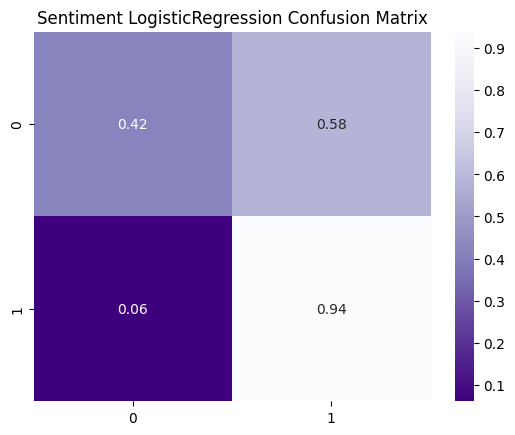

Running... MultinomialNB Model
Best hyperparameters for MultinomialNB: {'classifier__alpha': 0.1}
Cross Validation Score: 0.806
Test Accuracy Score: 0.8059981255857545
F1 Score: 0.7853

Classification Report for MultinomialNB Model:
              precision    recall  f1-score   support

          -1       0.69      0.39      0.50       526
           1       0.82      0.94      0.88      1608

    accuracy                           0.81      2134
   macro avg       0.76      0.67      0.69      2134
weighted avg       0.79      0.81      0.79      2134



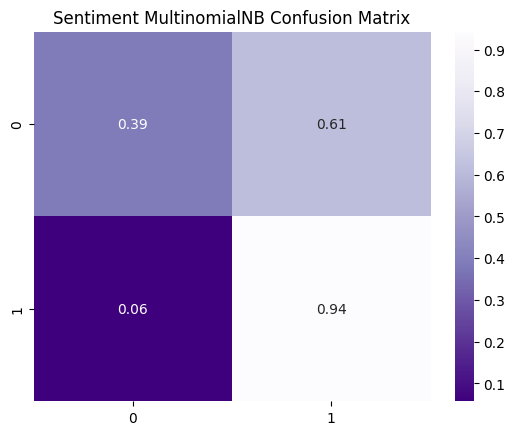

Running... DecisionTree Model
Best hyperparameters for DecisionTree: {'classifier__max_depth': 30, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Cross Validation Score: 0.7816
Test Accuracy Score: 0.781630740393627
F1 Score: 0.7558

Classification Report for DecisionTree Model:
              precision    recall  f1-score   support

          -1       0.61      0.32      0.42       526
           1       0.81      0.93      0.87      1608

    accuracy                           0.78      2134
   macro avg       0.71      0.63      0.64      2134
weighted avg       0.76      0.78      0.76      2134



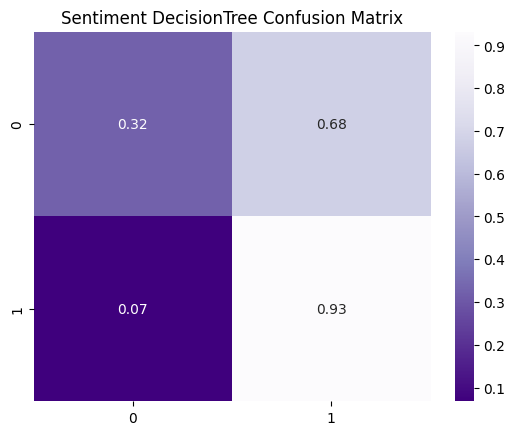

Running... RandomForest Model
Best hyperparameters for RandomForest: {'classifier__max_depth': None, 'classifier__n_estimators': 50}
Cross Validation Score: 0.8102
Test Accuracy Score: 0.810215557638238
F1 Score: 0.7768

Classification Report for RandomForest Model:
              precision    recall  f1-score   support

          -1       0.80      0.31      0.44       526
           1       0.81      0.97      0.89      1608

    accuracy                           0.81      2134
   macro avg       0.80      0.64      0.67      2134
weighted avg       0.81      0.81      0.78      2134



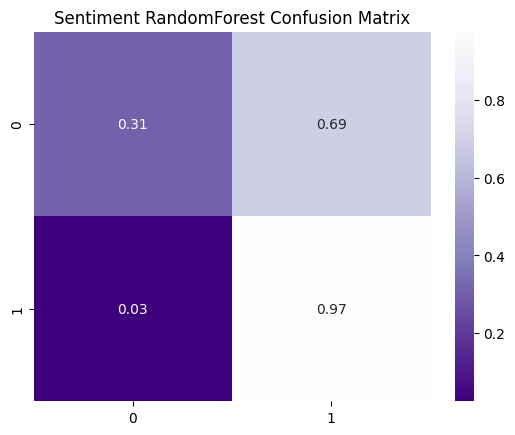

Running... ExtraTrees Model
Best hyperparameters for ExtraTrees: {'classifier__max_depth': None, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200}
Cross Validation Score: 0.8135
Test Accuracy Score: 0.8134957825679475
F1 Score: 0.7863

Classification Report for ExtraTrees Model:
              precision    recall  f1-score   support

          -1       0.77      0.35      0.48       526
           1       0.82      0.97      0.89      1608

    accuracy                           0.81      2134
   macro avg       0.79      0.66      0.68      2134
weighted avg       0.81      0.81      0.79      2134



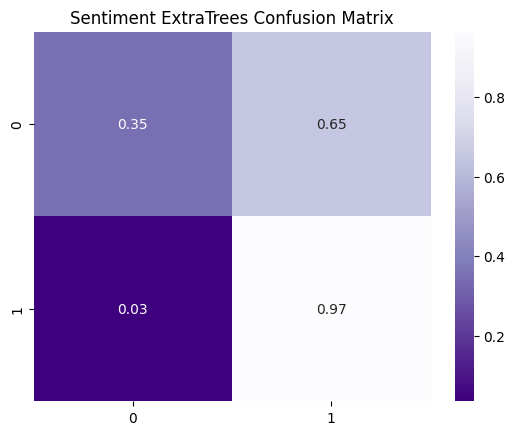

Running... GradientBoost Model
Best hyperparameters for GradientBoost: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 300}
Cross Validation Score: 0.8027
Test Accuracy Score: 0.802717900656045
F1 Score: 0.7857

Classification Report for GradientBoost Model:
              precision    recall  f1-score   support

          -1       0.66      0.41      0.51       526
           1       0.83      0.93      0.88      1608

    accuracy                           0.80      2134
   macro avg       0.74      0.67      0.69      2134
weighted avg       0.79      0.80      0.79      2134



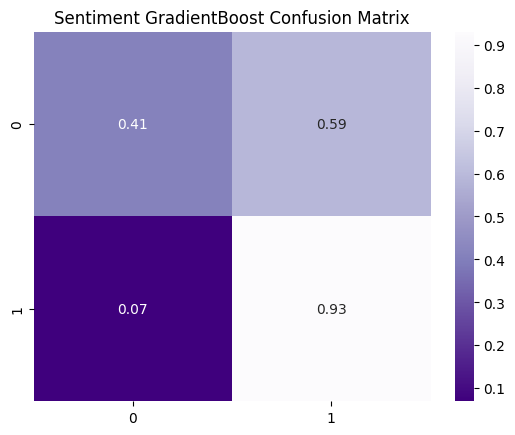

Running... SGDClassifier Model
Best hyperparameters for SGDClassifier: {'classifier__alpha': 0.0001, 'classifier__loss': 'log', 'classifier__penalty': 'l1'}
Cross Validation Score: 0.8149
Test Accuracy Score: 0.8149015932521088
F1 Score: 0.8012

Classification Report for SGDClassifier Model:
              precision    recall  f1-score   support

          -1       0.69      0.46      0.55       526
           1       0.84      0.93      0.88      1608

    accuracy                           0.81      2134
   macro avg       0.76      0.69      0.72      2134
weighted avg       0.80      0.81      0.80      2134



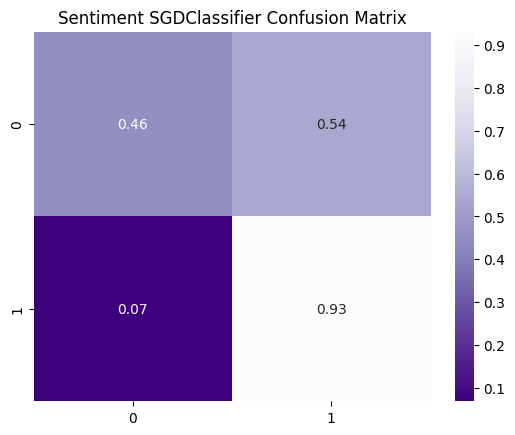

In [30]:
cmap = 'Purples_r'  # Define the colormap variable

# Run the function on the data with k-fold cross-validation (n_splits=3)
metric_table_train = run_model_with_grid_search_and_cv(default_models, 'Sentiment', cmap, X_train, y_train, n_splits=5)

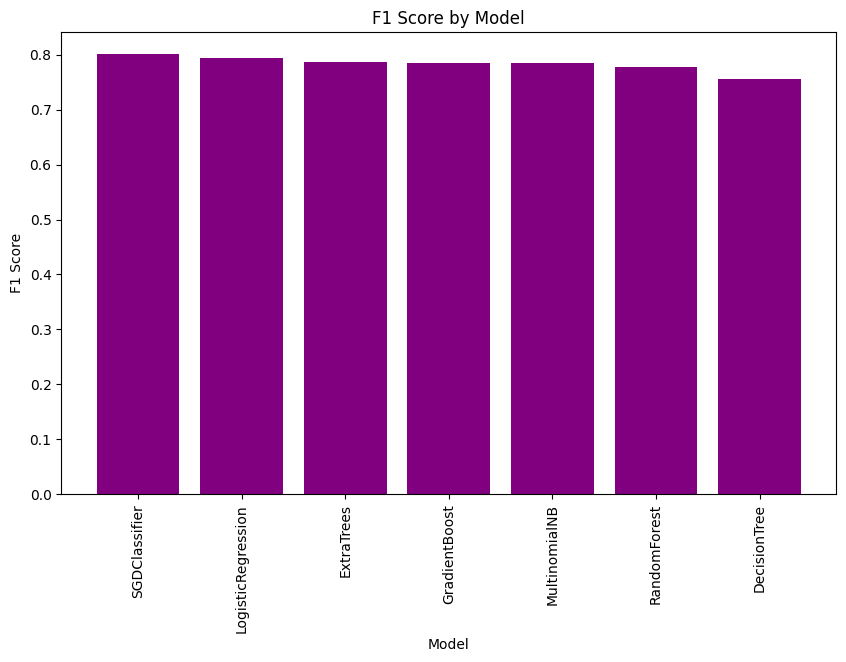

In [31]:
# Sort the DataFrame by F1 Score in descending order
metric_table_sorted = metric_table_train.sort_values('F1 Score', ascending=False)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(metric_table_sorted['Model'], metric_table_sorted['F1 Score'], color='purple')

# Add labels and title
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('F1 Score by Model')

# Display the chart
plt.xticks(rotation='vertical')
plt.show()


# Next Steps
* Acquire recent data from Twitter.
* Look into alternate ways of dealing with the imbalanced data.
* Use deep learning models to capture complex patterns in the data.
* Hand review target/sentiment to imporve sentiment classification.

# Conclusion
We were able to get an F1 score of 80% by using stochastic gradient descent (SGD) and if we continue to develop this model and the underlying data we can improve this score further. Based on the word clouds we suggest that Apple's product development team and marketing team focus on app functionality, improving battery life and ensure design is appealing to customers. We can use this model to test small changes to apps by utilizing new twitter data.
